In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

In [3]:
#gt = np.zeros((480, 854))
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/train/00023.png")[16:-16,11:-11]
# plt.imshow(gt, cmap='gray')

In [4]:
flow = np.zeros((448, 832, 2))

In [5]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [6]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [7]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [8]:
rgb0 = rgb0[:,16:-16,11:-11,:]
rgb1 = rgb1[:,16:-16,11:-11,:]

In [9]:
lambdaTensor = tf.placeholder(tf.float32)
sLoss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, 1)

tLoss = pLoss + lambdaTensor * sLoss

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
sGrad = tf.gradients(sLoss, flow)
pGrad = tf.gradients(pLoss, flow)
tGrad = tf.gradients(tLoss, flow)

In [11]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [12]:
itr = 1000
solver, solver_op, learningRateTensor = attach_ADAM_Solver(tLoss)

In [14]:
init = tf.global_variables_initializer()
sLosses = []
pLosses = []
sGrads = []
pGrads = []
tGrads = []
flows = []
start_time = None
print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            lambdaTensor: 4.0e4
        }
        _, p, s, f, pg, sg = sess.run([solver_op, pLoss, sLoss, flow, pGrad, sGrad], feed_dict = feed_dict)
        if i % print_freq == 1:
            print(i)
            pLosses.append(np.mean(p))
            sLosses.append(np.mean(s))
            flows.append(deepcopy(f[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss: %f" % float(sLosses[-1])

            pGrads.append(np.median(np.abs(pg[0])))
            sGrads.append(np.median(np.abs(sg[0])))

1
Photo loss: 2944.343994
Smooth loss: 0.000004
11
Photo loss: 2108.018555
Smooth loss: 1.210651
21
Photo loss: 2064.137451
Smooth loss: 0.334229
31
Photo loss: 2009.648315
Smooth loss: 0.112299
41
Photo loss: 1892.831787
Smooth loss: 0.049474
51
Photo loss: 1783.370728
Smooth loss: 0.022188
61
Photo loss: 1696.745483
Smooth loss: 0.011664
71
Photo loss: 1629.952637
Smooth loss: 0.007800
81
Photo loss: 1576.210205
Smooth loss: 0.006376
91
Photo loss: 1529.300537
Smooth loss: 0.005841
101
Photo loss: 1485.586914
Smooth loss: 0.005616
111
Photo loss: 1442.270630
Smooth loss: 0.005507
121
Photo loss: 1398.872559
Smooth loss: 0.005462
131
Photo loss: 1353.005615
Smooth loss: 0.005453
141
Photo loss: 1307.237671
Smooth loss: 0.005447
151
Photo loss: 1261.895630
Smooth loss: 0.005453
161
Photo loss: 1217.829224
Smooth loss: 0.005467
171
Photo loss: 1173.929077
Smooth loss: 0.005466
181
Photo loss: 1130.943481
Smooth loss: 0.005466
191
Photo loss: 1089.978760
Smooth loss: 0.005455
201
Photo l

max flow: 8.4283
flow range:
u = -3.831 .. 7.683
v = -5.719 .. 5.583


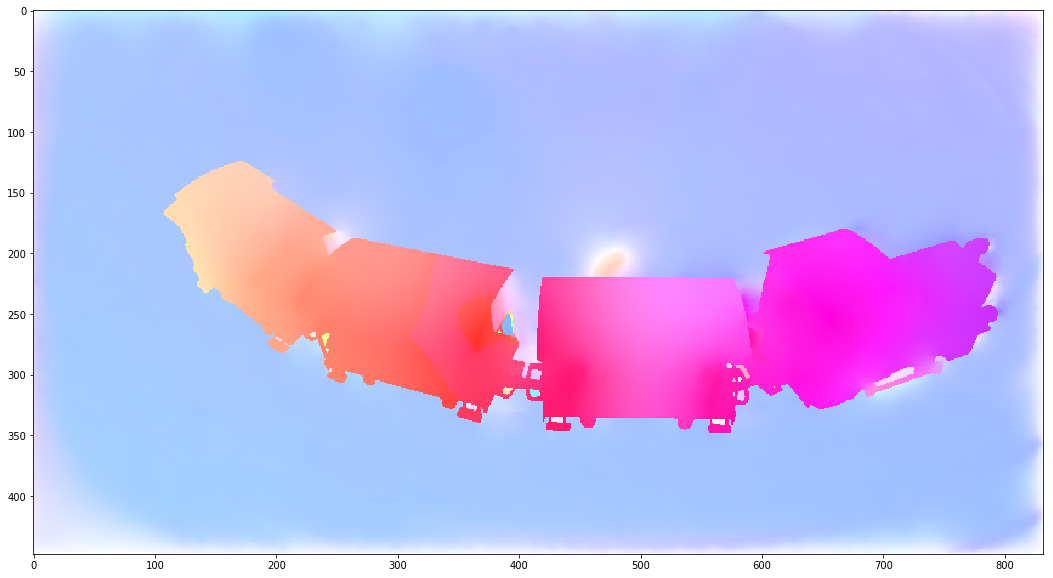

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(flow_to_image(flows[-1]))